In [1]:
#import scrublet as scr
import numpy as np
import pandas as pd
import statistics as st
import re
import csv
import scanpy as sc 
import scanpy.external as sce
import phate
import matplotlib
from matplotlib import pyplot as plt
import warnings
from scipy.stats import binom
from scipy.stats import multinomial
import seaborn
from scipy.stats import hypergeom
import warnings
warnings.filterwarnings('ignore')
import scrublet as scr
import harmonypy as hm
from random import sample
import pickle

In [2]:
PATH = '../../Data/Pickles/'
Dict_File = open(PATH + "CM_FILTERED_DICT_080521.pkl", "rb")
CM_FILTERED_DICT = pickle.load(Dict_File)

### Load Dataset (Focused)

In [3]:
Focused_SG = pd.read_pickle('./Focused_SGRNA_IND_091121.pkl')

In [4]:
Focused_SC = sc.read_h5ad('./Focused_SC_091121.h5ad')

### Process sgRNA

In [5]:
cell_list = []
for cell in Focused_SG.index:
    if cell in Focused_SC.obs.index:
        cell_list.append(cell)
Focused_SG = Focused_SG.loc[cell_list]

In [6]:
### Make Dict of sgRNA 
SG_Targets = []
for sg in Focused_SG.columns:
    SG_Targets.append(sg.split('_')[0])
SG_Targets = np.unique(SG_Targets)

SG_Name = []
SG_Indi = []
for sg in SG_Targets:
    if sg == 'NC_Blank':
        SG_Name.append('NC')
        SG_Indi.append('NC_Blank')
    else:
        SG_Name.append(sg)
        sg_list = []
        for indi in Focused_SG.columns:
            if indi.split('_')[0] == sg:
                sg_list.append(indi)
        SG_Indi.append(sg_list)
Focused_Guide_Dictionary = dict(zip(SG_Name, SG_Indi))

In [7]:
### Cells for each sgRNA
Cell_List = []
for target in Focused_SG.columns:
    Cell_Subset = []
    if target == 'NC_Blank':
        for cell in Focused_SG.index:
            if sum(Focused_SG.loc[cell] >0) != 1:
                continue
            if Focused_SG.loc[cell][target] >0:
                Cell_Subset.append(cell)
    else:
        [Cell_Subset.append(i) for i in Focused_SG[Focused_SG[target] > 0].index]
    Cell_List.append(Cell_Subset)
Focused_SG_Dictionary = dict(zip(Focused_SG.columns, Cell_List))

In [8]:
### List of perturbed cells
Perturbed_Cells = []
for target in Focused_Guide_Dictionary.keys():
    if target == 'NC':
        continue
        
    Filtered_SG = [i for i in Focused_Guide_Dictionary[target] if int(i.split('_')[1]) not in CM_FILTERED_DICT[target]]
    for i in Filtered_SG:
        Perturbed_Cells.extend(Focused_SG_Dictionary[i])
    
Focused_Perturbed_Cells = np.unique(Perturbed_Cells)

In [9]:
sg_id = []
for cell in Focused_SC.obs.index:
    if cell in Focused_SG_Dictionary['NC_Blank']:
        sg_id.append('NC')
    elif cell in Focused_Perturbed_Cells:
        sg_id.append('sgTBX5Enh')
    else:
        sg_id.append('Other')
Focused_SC.obs['sg_id'] = sg_id

In [10]:
Focused_SC_DF = Focused_SC[Focused_SC.obs.sg_id != 'Other']

### Load Dataset (Large_Scale)

In [11]:
Large_SG_DF = pd.read_pickle('./DAP3_SGRNA_IND_072821.pkl')

In [12]:
New_NC_Name = ['NC:1', 'NC:2', 'NC:3', 'NC:4', 'NC:5']
NC_Guide_List= ['NC_GAG', 'NC_GFP', 'NC_GFP_1', 'NC_GFP_2', 'NC_HS2']
NC_DICT = dict(zip(NC_Guide_List, New_NC_Name))
new_name = []
for col in Large_SG_DF.columns:
    if col in NC_Guide_List:
        new_name.append(NC_DICT[col])
    else:
        new_name.append(col)
Large_SG_DF.columns = new_name

In [13]:
Large_SC_DF= sc.read_h5ad('./DAP3_SC_072821.h5ad')

### Process sgRNA

In [14]:
### single cell dataset already selected for sg cells. just need to subset sgdf
Large_SG_DF = Large_SG_DF.loc[Large_SC_DF.obs.index]

In [15]:
## Unique list
Target_List = []
for target in Large_SG_DF.columns:
    Target_List.append(target.split(':')[0])
Unique_Target_List = np.unique(Target_List)

In [16]:
# Dictionary to get individual sg name
Target_Name = []
Target_Guides = []

for target in Unique_Target_List:
    Target_Name.append(target)
    if Target_List.count(target) == 1:
        Target_Guides.append(target)
    else:
        Target_Guide_Range = list(range(Target_List.count(target)))
        
        Subset_Guides = []
        
        if target in CM_FILTERED_DICT.keys():
            for guide in Target_Guide_Range:
                if guide + 1 not in CM_FILTERED_DICT[target]:
                    Subset_Guides.append(target + ':' + str(guide + 1))
        
        else:
            for guide in Target_Guide_Range:
                Subset_Guides.append(target + ':' + str(guide + 1))
        Target_Guides.append(Subset_Guides)
CM_Filtered_Guide_Dictionary = dict(zip(Target_Name,Target_Guides))

In [17]:
# Dictionary to get individual sg name
Target_Name = []
Target_Guides = []

for target in Unique_Target_List:
    Target_Name.append(target)
    if Target_List.count(target) == 1:
        Target_Guides.append(target)
    else:
        Target_Guide_Range = list(range(Target_List.count(target)))
        
        Subset_Guides = []
        for guide in Target_Guide_Range:
            Subset_Guides.append(target + ':' + str(guide + 1))
        Target_Guides.append(Subset_Guides)
Large_Guide_Dictionary = dict(zip(Target_Name,Target_Guides))

### To treat NC as one target

In [18]:
### Sequester individual NCs
sg_bool = Large_SG_DF > 0
sg_pos = []
for cell in sg_bool.index:
    if sum(sg_bool.loc[cell]) == 1:
        sg_pos.append(cell)
Large_SG_INDI = Large_SG_DF.loc[sg_pos]

NC_GAG_List = Large_SG_INDI[Large_SG_INDI['NC:1'] > 0].index.tolist()
NC_GFP_List = Large_SG_INDI[Large_SG_INDI['NC:2'] > 0].index.tolist()
NC_GFP_1_List = Large_SG_INDI[Large_SG_INDI['NC:3'] > 0].index.tolist()
NC_GFP_2_List = Large_SG_INDI[Large_SG_INDI['NC:4'] > 0].index.tolist()
NC_HS2_List = Large_SG_INDI[Large_SG_INDI['NC:5'] > 0].index.tolist()

In [19]:
Single_Guide_List= ['NC_GAG', 'NC_GFP', 'NC_GFP_1', 'NC_GFP_2', 'NC_HS2', 'MALAT1']

In [20]:
NC_Guide_List= ['NC_GAG', 'NC_GFP', 'NC_GFP_1', 'NC_GFP_2']

In [21]:
Clean_NC_Cells = NC_GAG_List + NC_GFP_List + NC_GFP_1_List + NC_GFP_2_List

In [22]:
ALL_NC_LISTS = [NC_GAG_List, NC_GFP_List, NC_GFP_1_List, NC_GFP_2_List]

In [23]:
New_NC_Name = ['NC:1', 'NC:2', 'NC:3', 'NC:4']
NC_NAME_DICT = dict(zip(NC_Guide_List, New_NC_Name))
Col_Name = []
for col in Large_SG_DF.columns:
    if col in NC_NAME_DICT.keys():
        Col_Name.append(NC_NAME_DICT[col])
    else:
        Col_Name.append(col)
Large_SG_DF.columns = Col_Name

In [24]:
# Dictionary to get cells for any given guide
Target_K = []
Target_V = []

for target in Large_SG_DF.columns:
    Target_K.append(target)
    Target_V.append(Large_SG_DF[Large_SG_DF[target] > 0 ].index.tolist())
Large_SGRNA_CELLS_DIC = dict(zip(Target_K, Target_V))
Large_Guide_Dictionary['NC'] = New_NC_Name

In [25]:
NC_DICT = dict(zip(New_NC_Name,ALL_NC_LISTS))

In [26]:
Target_SG = []
Target_SG_Grouped = []

TBX5Enh_Set = ['TBXEnh1', 'TBXEnh2', 'TBXEnh3', 'TBXEnh4', 'TBXEnh5', 'TBXEnh6']
Cell_List = []
for tar in TBX5Enh_Set:
    [Cell_List.extend(Large_SGRNA_CELLS_DIC[SG]) for SG in CM_Filtered_Guide_Dictionary[tar]]
Cell_List = np.unique(Cell_List)


for cell in Large_SC_DF.obs.index:
    if cell in Cell_List:
        Target_SG.append('sgTBX5Enh')
        Target_SG_Grouped.append('sgTBX5Enh')
    elif cell in Clean_NC_Cells:
        for NC in NC_DICT.keys():
            if cell in NC_DICT[NC]:
                Target_SG_Grouped.append('NC')
                Target_SG.append(NC)
    else:
        Target_SG.append('Other')
        Target_SG_Grouped.append('Other')

In [27]:
Large_SC_DF_Group = Large_SC_DF
Large_SC_DF_Group.obs['SG'] = Target_SG_Grouped
Large_SC_DF_Group_Subset = Large_SC_DF_Group[Large_SC_DF_Group.obs['SG'] != 'Other']


### Compare Repression

In [28]:
Gene = 'NPPA'

Focused_CM = Focused_SC_DF[Focused_SC_DF.obs.louvain == '2']
Large_CM = Large_SC_DF_Group_Subset[Large_SC_DF_Group_Subset.obs.louvain == '1']

Focused_Pos = np.argwhere(Focused_CM.raw.var_names == Gene)[0][0]
Large_Pos = np.argwhere(Large_CM.raw.var_names == Gene)[0][0]

In [29]:
Large_FC = (Large_CM[Large_CM.obs.SG == 'sgTBX5Enh'].raw.X[:,Large_Pos].mean()/np.log(2))/(Large_CM[Large_CM.obs.SG == 'NC'].raw.X[:,Large_Pos].mean()/np.log(2))
Focused_FC = (Focused_CM[Focused_CM.obs.sg_id == 'sgTBX5Enh'].raw.X[:,Focused_Pos].mean()/np.log(2))/(Focused_CM[Focused_CM.obs.sg_id == 'NC'].raw.X[:,Focused_Pos].mean()/np.log(2))                                                                              

In [35]:
Large_FC-Focused_FC

0.18484322680446574

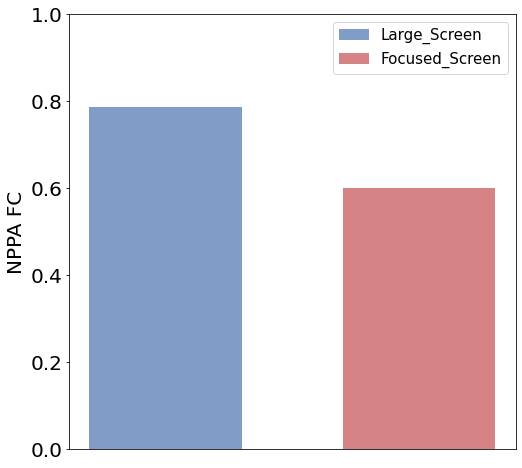

In [32]:
plt.rcParams.update({'font.size': 20})

fig, ax = plt.subplots(figsize=(8,8))

#labels = ['Cluster 0', 'Cluster 1', 'Cluster 2', 'Cluster 3','Cluster 4','Cluster 5','Cluster 6','Cluster 7']

N=1
ind = np.arange(N)

width = 0.3       # the width of the bars: can also be len(x) sequence

ax.bar(.5, Large_FC, width, alpha = 0.7, label='Large_Screen', color = '#4c72b0')
ax.bar(1, Focused_FC, width,  alpha = 0.7,
       label='Focused_Screen', color ='#c44e52')

ax.set_ylabel('NPPA FC')
plt.xticks(ind + width*.5)
plt.ylim(0,1)
ax.legend()
plt.legend(prop={'size': 15})
plt.savefig('./NPPA_FC_Comparison.pdf')
plt.show()